In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import VotingClassifier
import pandas_market_calendars as mcal
import statsmodels.api as sm

#Load the data
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Return'] = data['Adj Close'].pct_change()
    return data

#Calculate the technical indicators
def calculate_indicators(data):
    data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Adj Close'].rolling(window=200).mean()
    data['Momentum'] = data['Adj Close'].pct_change(10)
    data['TSMOM'] = data['Return'].rolling(window=20).sum()

    data['EMA_12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Adj Close'].ewm(span=26, adjust=False).mean()
    data['ROC'] = data['Adj Close'].pct_change(periods=12)
    data['ATR'] = data['High'].rolling(window=14).std()

    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['MACDSignal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    data['BB_middle'] = data['Adj Close'].rolling(window=20).mean()
    std = data['Adj Close'].rolling(window=20).std()
    data['BB_upper'] = data['BB_middle'] + (std * 2)
    data['BB_lower'] = data['BB_middle'] - (std * 2)

    TP = (data['High'] + data['Low'] + data['Close']) / 3
    TP_sma = TP.rolling(window=20).mean()
    mad = lambda x: np.fabs(x - x.mean()).mean()
    data['CCI'] = (TP - TP_sma) / (0.015 * TP.rolling(window=20).apply(mad, raw=True))

    return data

# Generate the trading day count
def trading_days(start_date, end_date, calendar='NYSE'):
    nyse = mcal.get_calendar(calendar)
    trading_days = nyse.valid_days(start_date=start_date, end_date=end_date)
    return len(trading_days)

# Generate labels
def generate_labels(data):
    data['Future_Return'] = data['Return'].shift(-1)
    data['Label'] = np.where(data['Future_Return'] > 0, 1, 0)
    return data

# EDA
def perform_eda(data):
    print("Descriptive Statistics:\n", data.describe())

    plot_correlation_with_target(data, target='Return')

    # Correlation Heatmap
    corr_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

    data.hist(bins=50, figsize=(20, 15))
    plt.show()

    # Time series plot
    data.plot(subplots=True, figsize=(20, 15))
    plt.show()

# Function to plot correlation matrix with target
def plot_correlation_with_target(data, target='Return'):
    correlations = data.corr()[target].sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm", orient='h')

    plt.title(f'Correlation of Features with {target}', fontsize=16)
    plt.xlabel('Correlation Coefficient', fontsize=14)
    plt.ylabel('Features', fontsize=14)

    for i, v in enumerate(correlations):
        plt.text(v + 0.02 if v > 0 else v - 0.02, i, f"{v:.2f}", color='black', va="center")

    plt.tight_layout()
    plt.show()

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def visualize_strategy_vs_asset(data, ticker):
    # Calculate the cumulative return of the asset
    data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()

    # Ensure the index and data are numpy arrays
    dates = data.index.to_numpy()
    strategy_return = data['Cumulative_Strategy_Return'].to_numpy()
    asset_return = data['Cumulative_Asset_Return'].to_numpy()
    
    # Set up the plot
    plt.figure(figsize=(14, 7))
    
    # Plot cumulative strategy return
    plt.plot(dates, strategy_return, label='Cumulative Strategy Return', color='blue')
    
#     # Plot cumulative asset return
#     plt.plot(dates, asset_return, label='Cumulative Asset Return', color='orange')
    
    # Add titles and labels
    plt.title(f'Cumulative Return: Strategy vs Asset for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()

In [3]:
# Stepwise regression function
def stepwise_selection(data, target, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       max_features=3, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(data.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(target, sm.add_constant(pd.DataFrame(data[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add {best_feature} with p-value {best_pval}')
        
        # Stop if we have selected the maximum number of features
        if len(included) >= max_features:
            break
        
        # Backward step
        model = sm.OLS(target, sm.add_constant(pd.DataFrame(data[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval}')
        
        if not changed:
            break

    return included

def prepare_data_for_stepwise(data):
    # Drop rows with NaN values
    data = data.dropna()

    # Select features (all the indicators) and the target (return)
    features = data[['SMA_50', 'SMA_200', 'Momentum', 'TSMOM', 'EMA_12', 'EMA_26', 
                     'ROC', 'ATR', 'RSI', 'MACD', 'MACDSignal', 'BB_middle', 'BB_upper', 
                     'BB_lower', 'CCI']]
    target = data['Return']

    return features, target

Processing SPY...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Performing EDA for SPY
Descriptive Statistics:
               Open         High          Low        Close    Adj Close  \
count  1648.000000  1648.000000  1648.000000  1648.000000  1648.000000   
mean    371.316493   373.505892   368.959800   371.381105   354.061945   
std      79.346343    79.509168    79.183464    79.403462    85.421982   
min     228.190002   229.679993   218.259995   222.949997   208.617661   
25%     291.082497   292.347488   289.887512   290.992493   267.800690   
50%     381.364990   384.555008   378.350006   381.330002   366.822571   
75%     435.084991   437.332489   432.485001   435.000000   420.350288   
max     562.869995   565.159973   562.099976   564.859985   563.132690   

             Volume       Return       SMA_50      SMA_200     Momentum  ...  \
count  1.648000e+03  1647.000000  1599.000000  1449.000000  1638.000000  ...   
mean   8.443992e+07     0.000583   352.782983   350.612015     0.005654  ...   
std    4.187119e+07     0.012446    81.58801

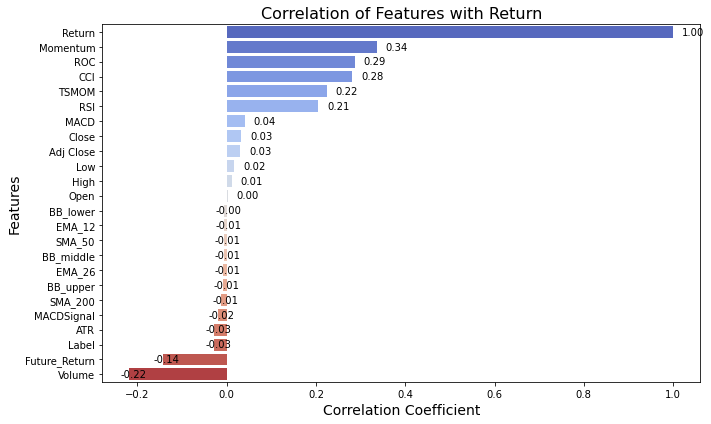

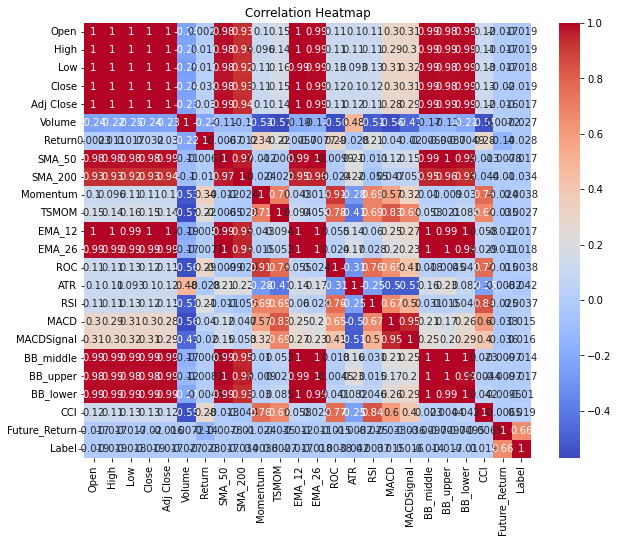

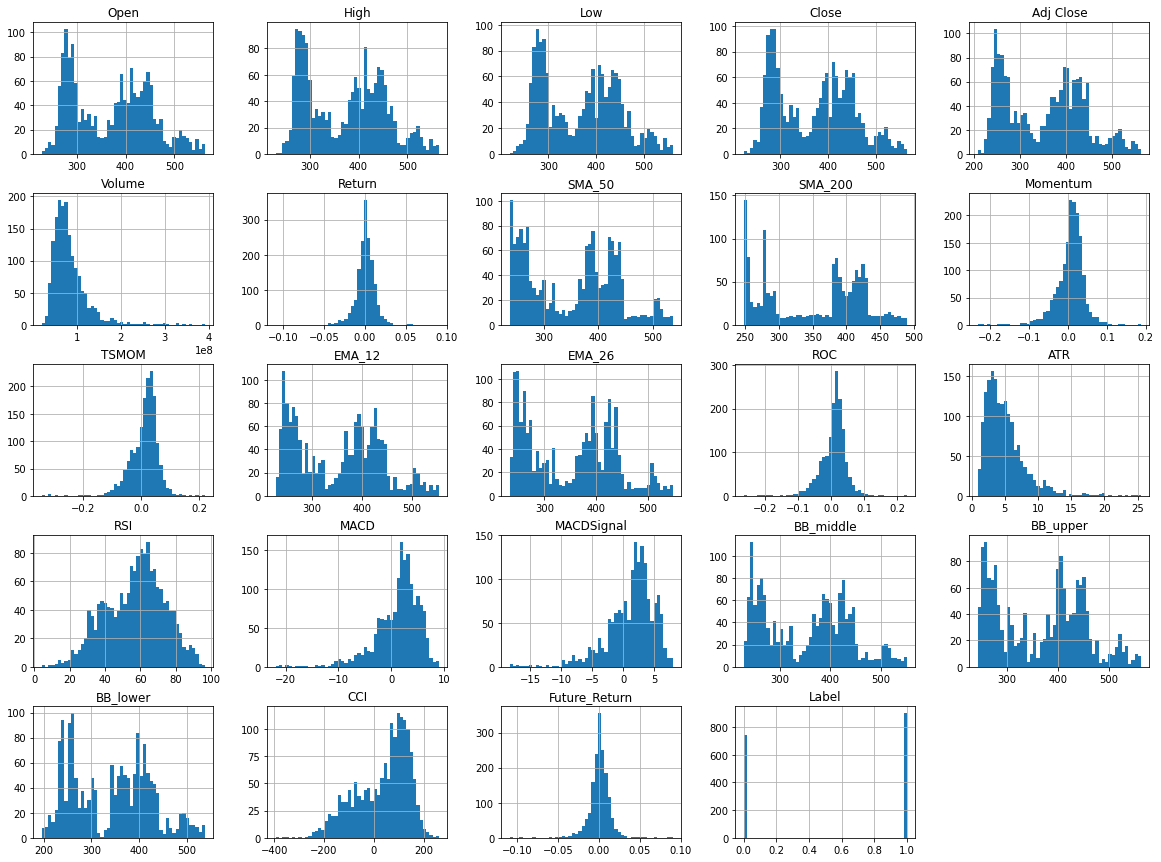

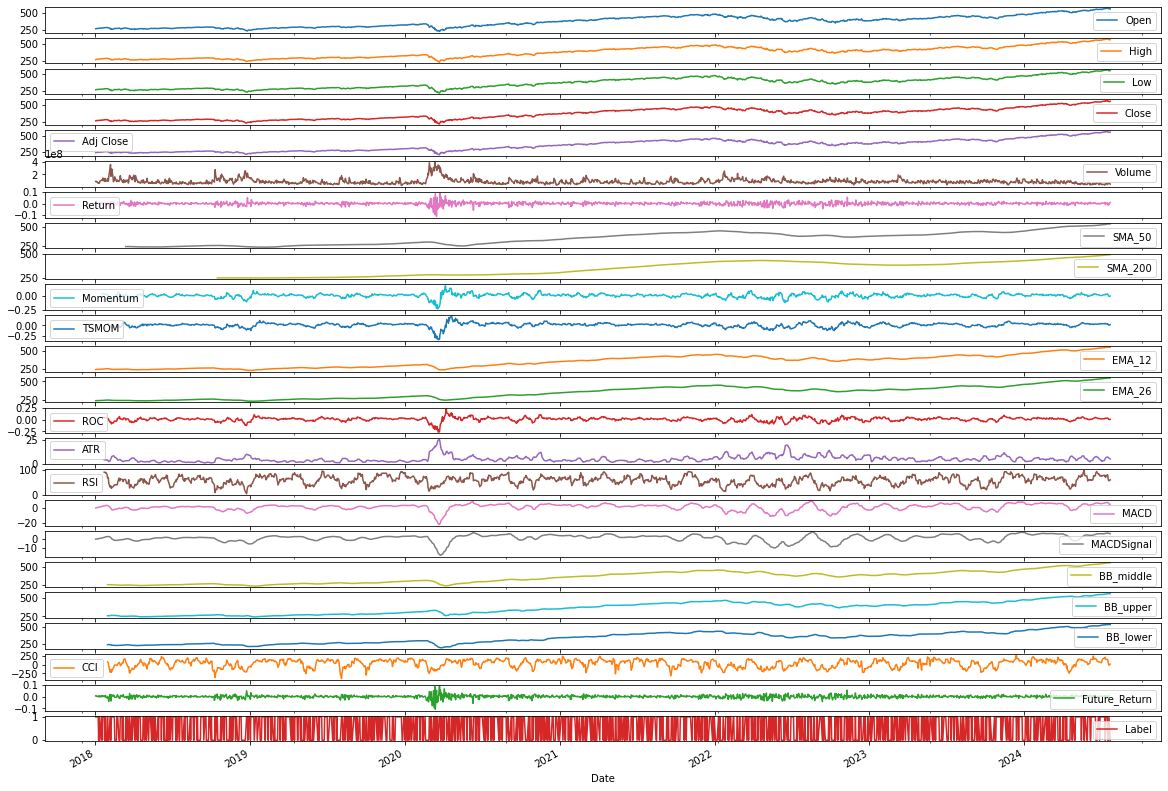

Add Momentum with p-value 2.246972873406059e-40
Add MACD with p-value 2.0565587096118918e-14
Add MACDSignal with p-value 2.3281910012470103e-29
Selected Features from Stepwise Regression for SPY: ['Momentum', 'MACD', 'MACDSignal']
Processing QQQ...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Performing EDA for QQQ
Descriptive Statistics:
               Open         High          Low        Close    Adj Close  \
count  1648.000000  1648.000000  1648.000000  1648.000000  1648.000000   
mean    284.064672   286.285777   281.687482   284.144824   278.661239   
std      89.438351    89.889808    88.894045    89.443075    90.530232   
min     145.080002   147.979996   143.460007   143.500000   138.255432   
25%     188.787498   190.082504   187.339996   188.840004   182.930233   
50%     290.410004   293.460007   287.539993   290.324997   284.951340   
75%     358.215012   360.507507   354.492508   358.165001   352.614456   
max     503.070007   503.519989   498.390015   502.959991   502.254211   

             Volume       Return       SMA_50      SMA_200     Momentum  ...  \
count  1.648000e+03  1647.000000  1599.000000  1449.000000  1638.000000  ...   
mean   4.735346e+07     0.000821   277.448442   275.394899     0.007974  ...   
std    2.273309e+07     0.015342    86.44111

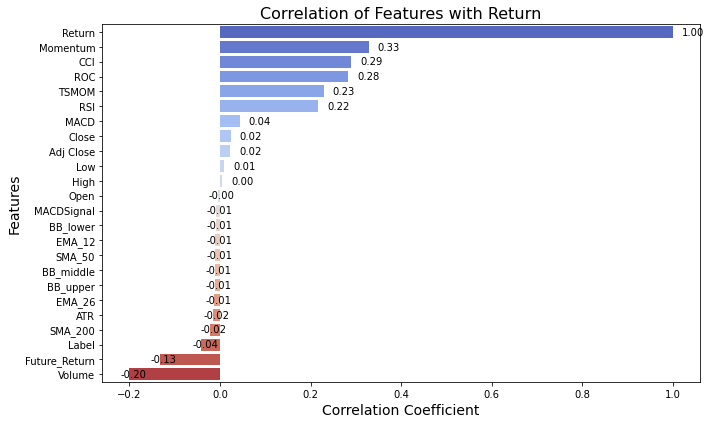

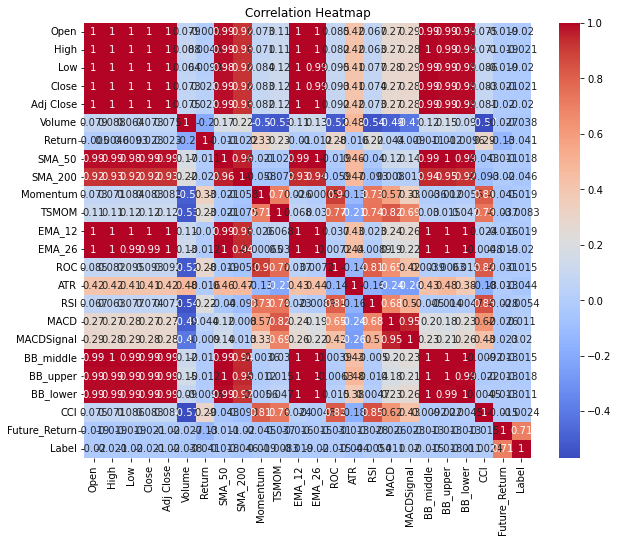

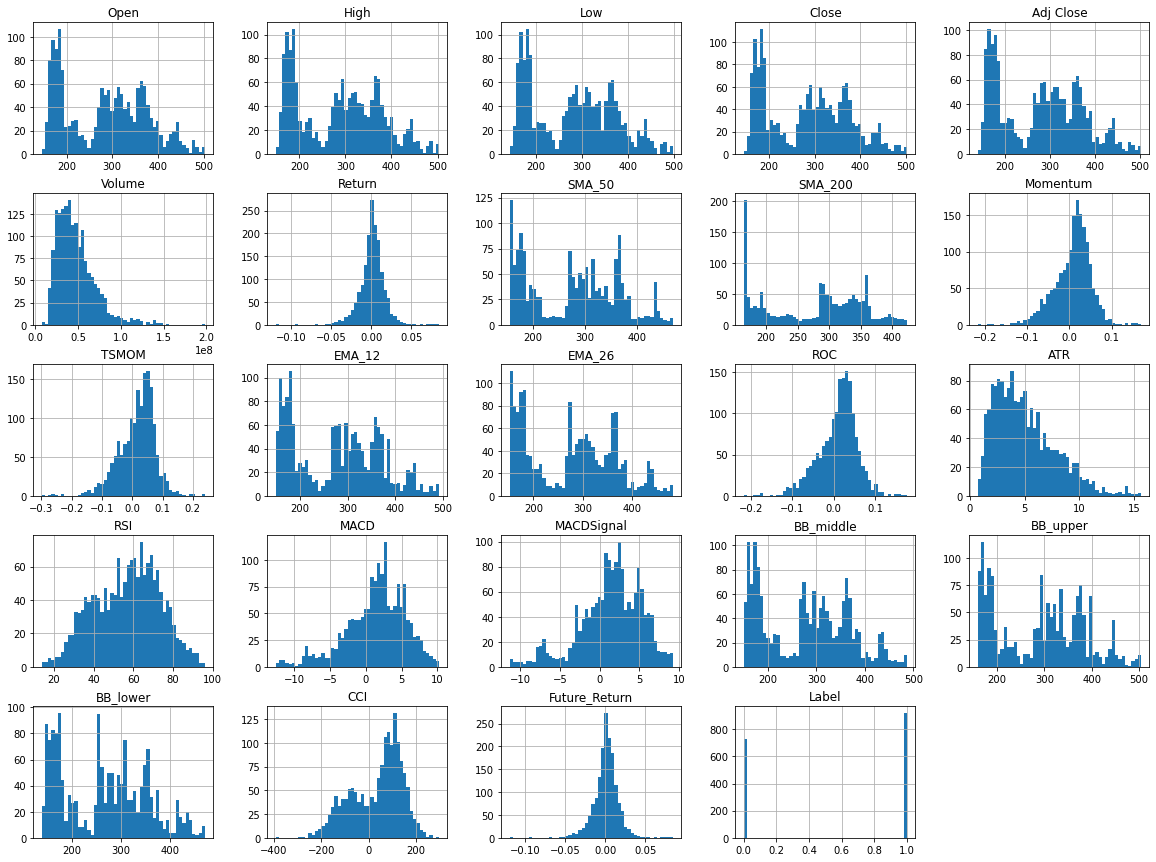

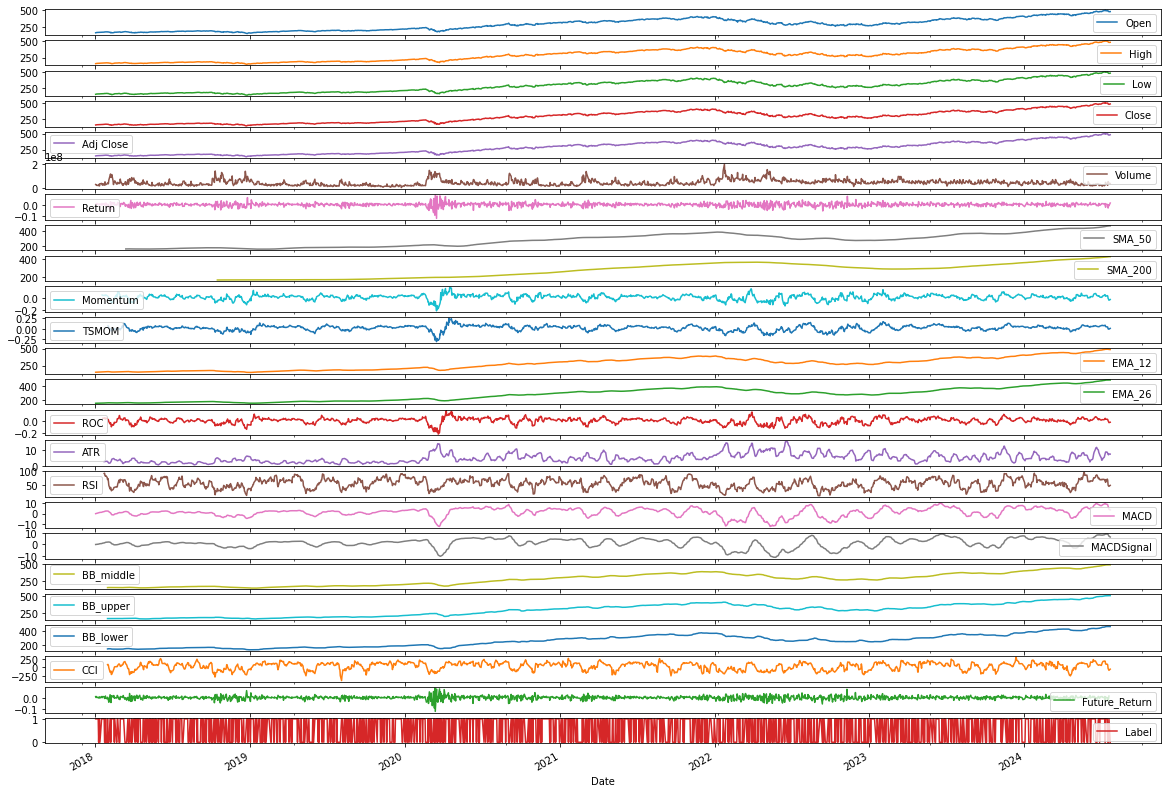

Add Momentum with p-value 6.377620935135218e-39
Add MACD with p-value 3.444667767364637e-13
Add MACDSignal with p-value 5.077888258416475e-25
Selected Features from Stepwise Regression for QQQ: ['Momentum', 'MACD', 'MACDSignal']
Processing DIA...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Performing EDA for DIA
Descriptive Statistics:
               Open         High          Low        Close    Adj Close  \
count  1648.000000  1648.000000  1648.000000  1648.000000  1648.000000   
mean    306.522379   308.219969   304.687106   306.548295   288.311542   
std      46.958750    46.921899    47.066204    47.012582    53.857894   
min     190.130005   191.199997   182.100006   186.130005   171.071136   
25%     261.829987   262.660004   260.159996   261.510010   235.666100   
50%     311.650009   313.534988   309.380005   311.290009   294.750732   
75%     343.597496   345.527504   341.882507   343.635002   329.465637   
max     410.679993   413.859985   408.559998   411.929993   410.183380   

             Volume       Return       SMA_50      SMA_200     Momentum  ...  \
count  1.648000e+03  1647.000000  1599.000000  1449.000000  1638.000000  ...   
mean   4.210988e+06     0.000453   287.708695   286.500591     0.004284  ...   
std    2.409708e+06     0.012397    51.78199

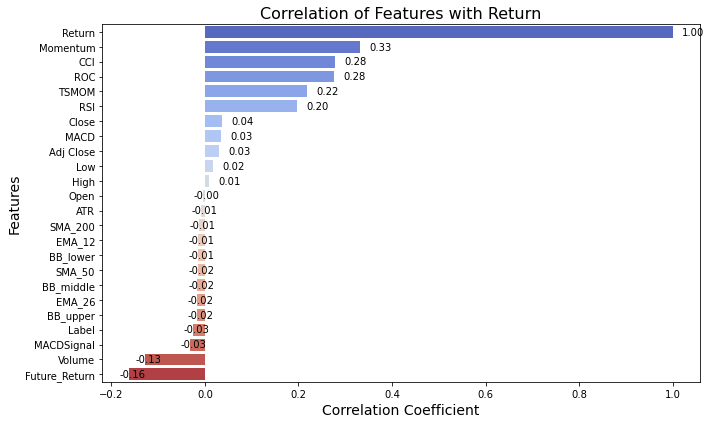

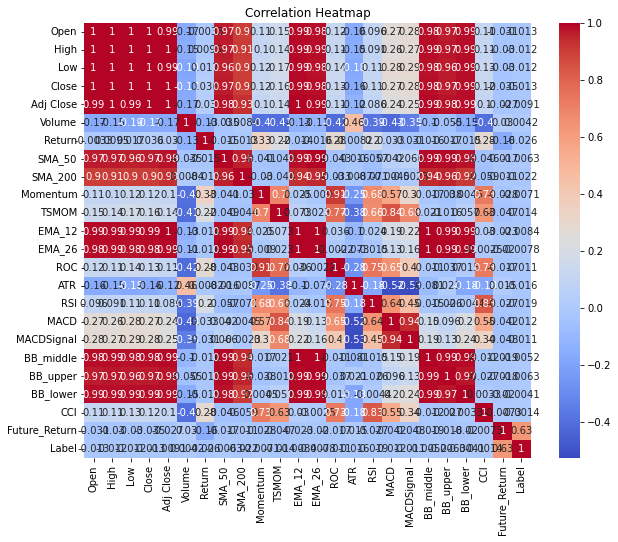

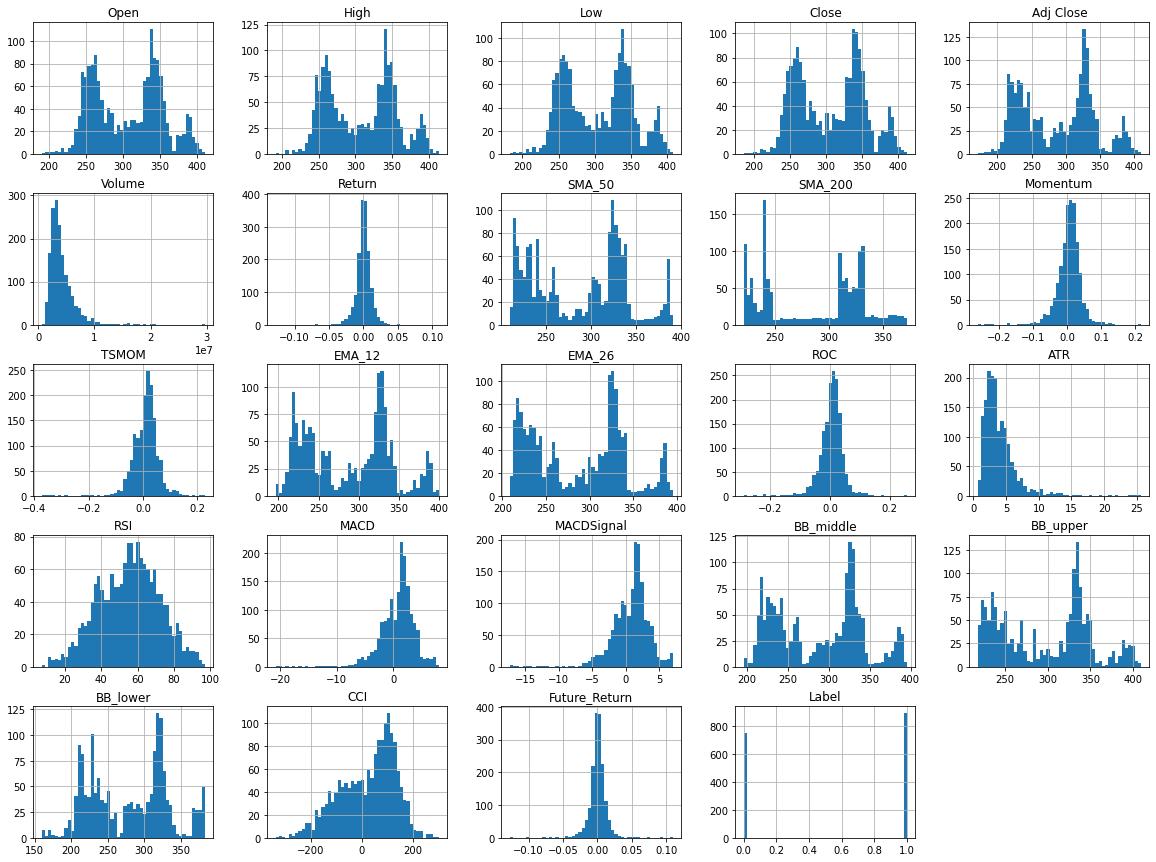

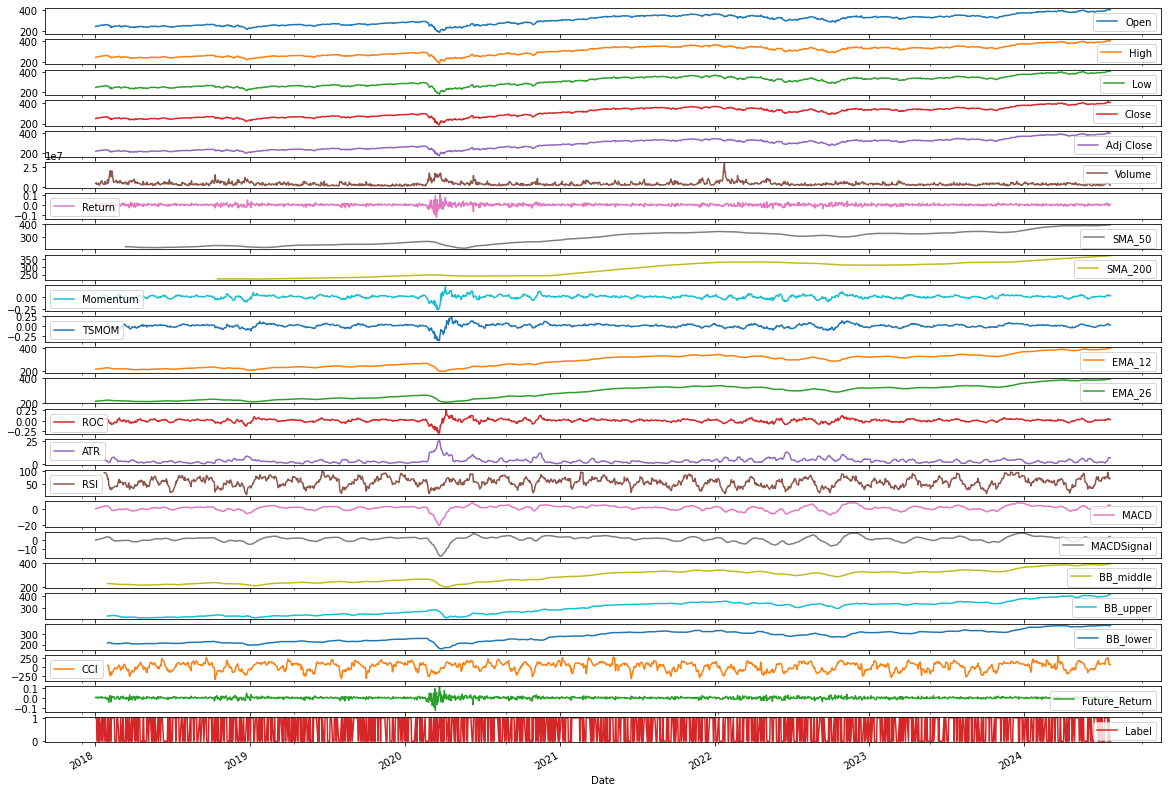

Add Momentum with p-value 2.3120677923661492e-39
Add MACD with p-value 1.015580883686886e-14
Add MACDSignal with p-value 2.2057796343157205e-30
Selected Features from Stepwise Regression for DIA: ['Momentum', 'MACD', 'MACDSignal']
Processing IWM...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Performing EDA for IWM
Descriptive Statistics:
               Open         High          Low        Close    Adj Close  \
count  1648.000000  1648.000000  1648.000000  1648.000000  1648.000000   
mean    178.173076   179.638968   176.492646   178.109691   170.378000   
std      27.741446    27.869269    27.587364    27.724513    28.820408   
min      99.660004   102.180000    95.690002    99.900002    93.943863   
25%     155.974998   156.909996   154.729996   156.095005   145.167816   
50%     174.279999   175.880005   172.459999   174.169998   169.858231   
75%     198.704998   200.650002   196.992504   199.039997   194.446121   
max     243.740005   244.460007   241.929993   242.559998   232.836624   

             Volume       Return       SMA_50      SMA_200     Momentum  ...  \
count  1.648000e+03  1647.000000  1599.000000  1449.000000  1638.000000  ...   
mean   2.789218e+07     0.000393   170.265280   170.077951     0.003671  ...   
std    1.205312e+07     0.015755    27.80615

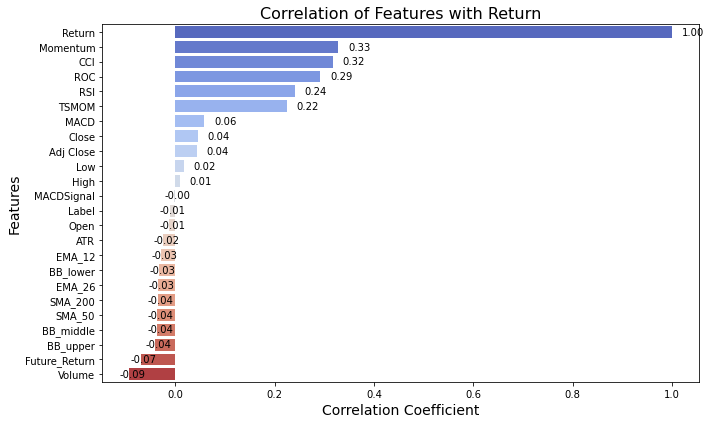

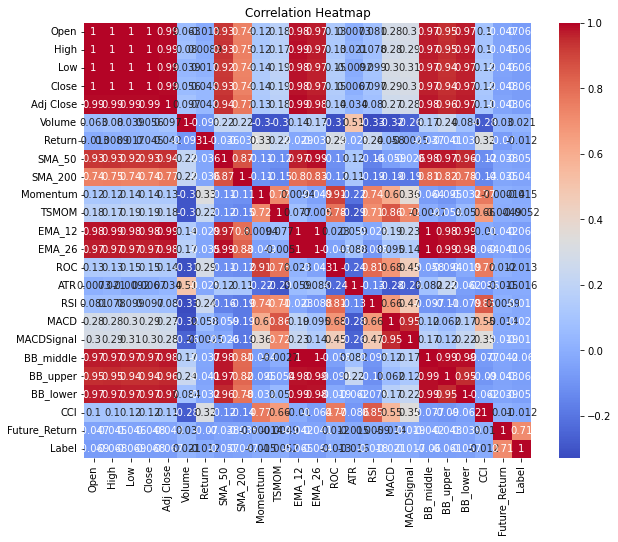

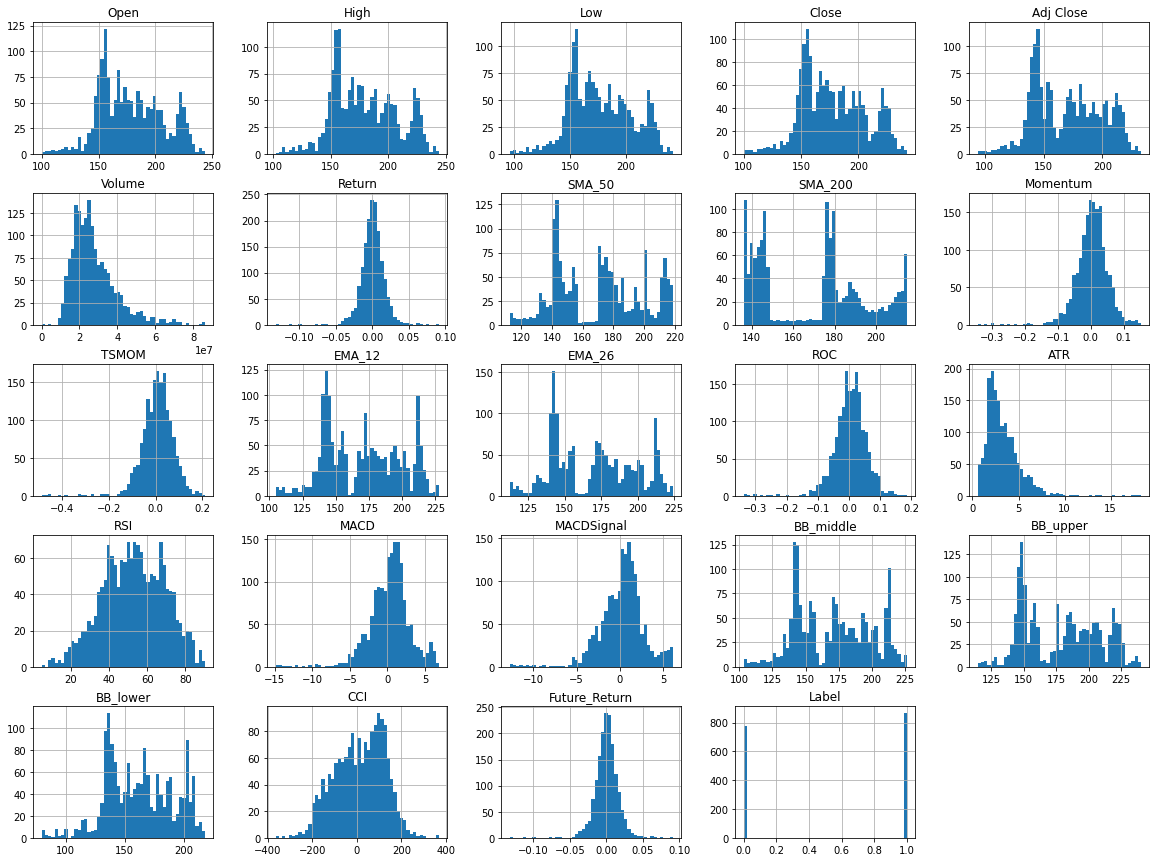

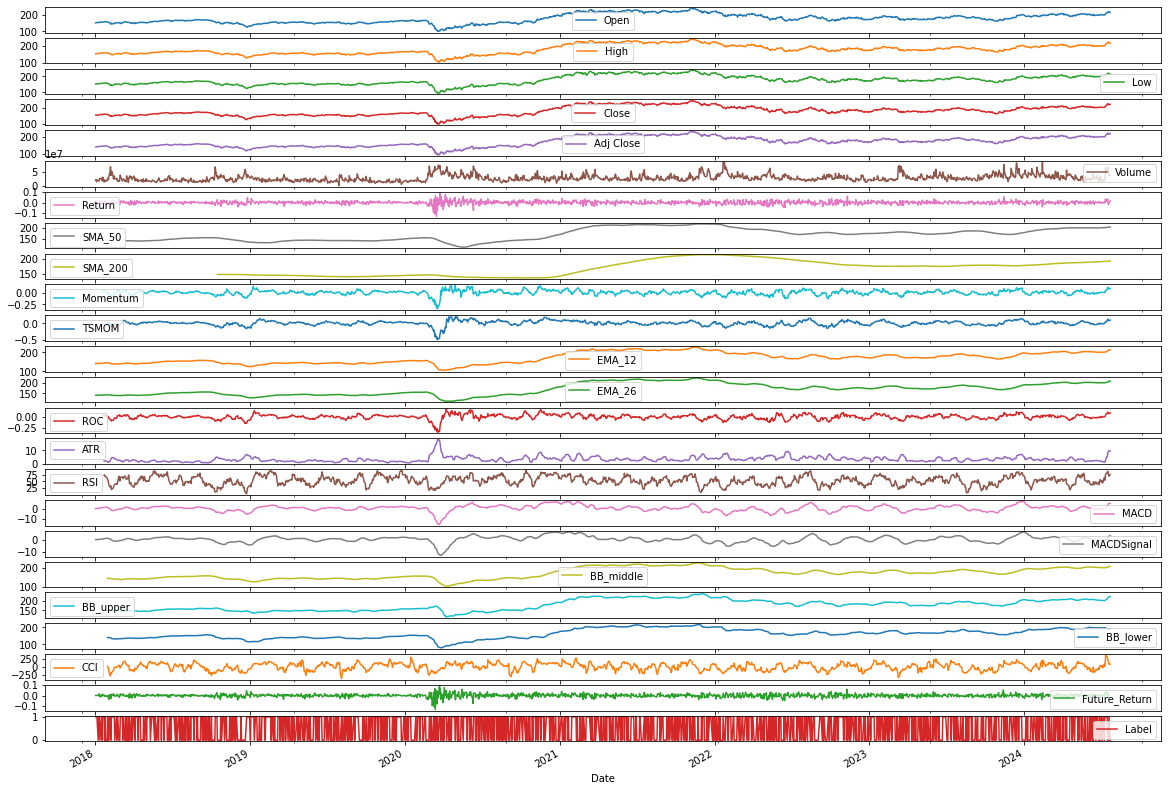

Add Momentum with p-value 9.585108609331785e-38
Add MACD with p-value 7.233446538452045e-13
Add MACDSignal with p-value 1.8055448038515001e-26
Selected Features from Stepwise Regression for IWM: ['Momentum', 'MACD', 'MACDSignal']
Processing VTI...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Performing EDA for VTI
Descriptive Statistics:
               Open         High          Low        Close    Adj Close  \
count  1648.000000  1648.000000  1648.000000  1648.000000  1648.000000   
mean    188.267791   189.331311   187.021881   188.265722   179.182178   
std      38.792501    38.869095    38.692480    38.796609    41.683437   
min     113.650002   114.900002   109.489998   111.910004   104.052391   
25%     149.134995   149.690002   148.212505   149.089996   136.283997   
50%     193.579994   195.055000   192.225006   193.870003   186.660324   
75%     219.969997   221.177498   218.482506   220.107498   212.764500   
max     277.600006   279.209991   277.399994   279.100006   278.241608   

             Volume       Return       SMA_50      SMA_200     Momentum  ...  \
count  1.648000e+03  1647.000000  1599.000000  1449.000000  1638.000000  ...   
mean   3.629527e+06     0.000562   178.625239   177.700099     0.005450  ...   
std    2.075794e+06     0.012726    39.89954

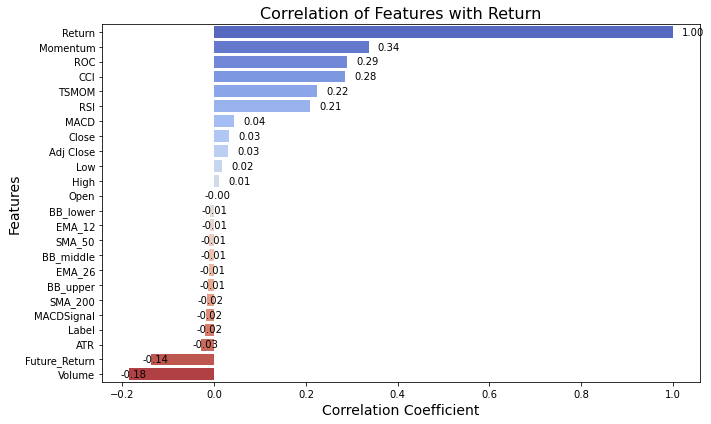

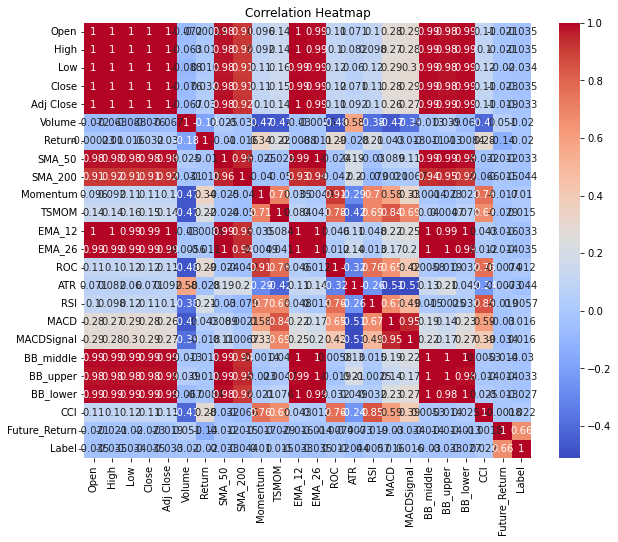

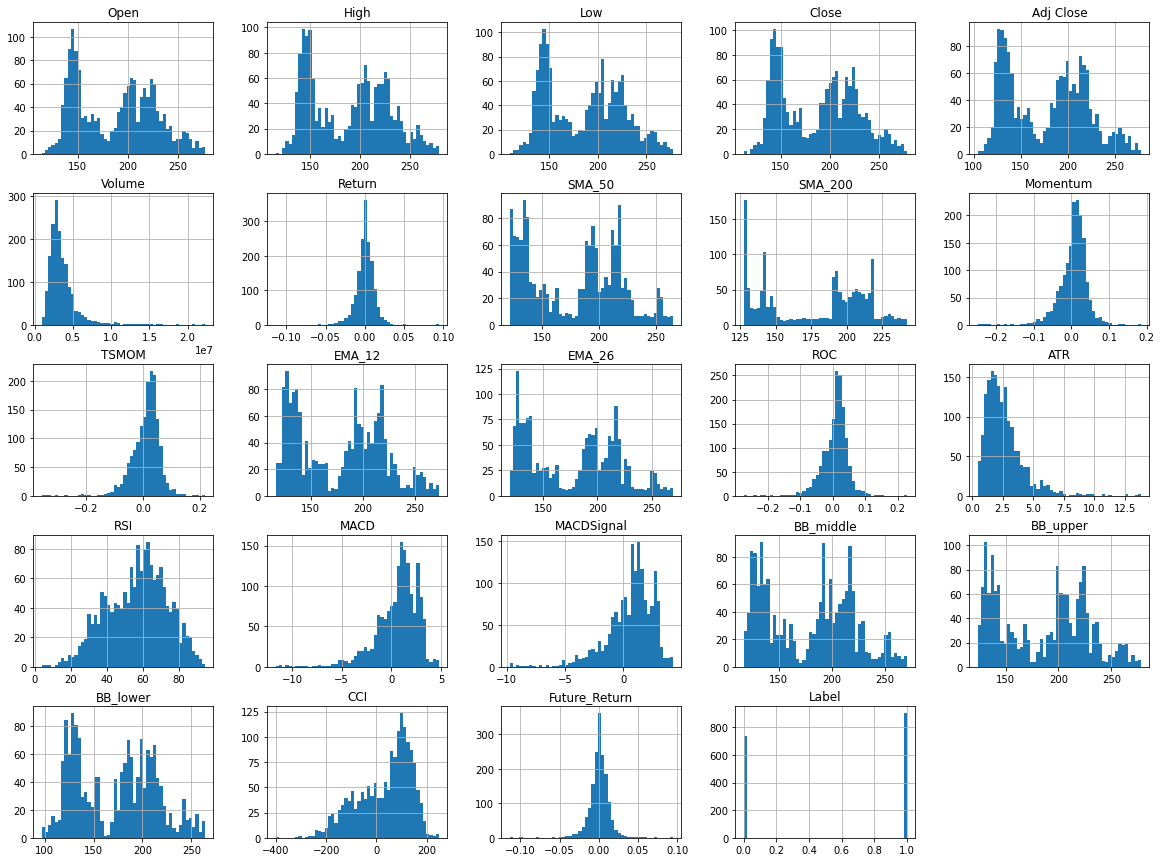

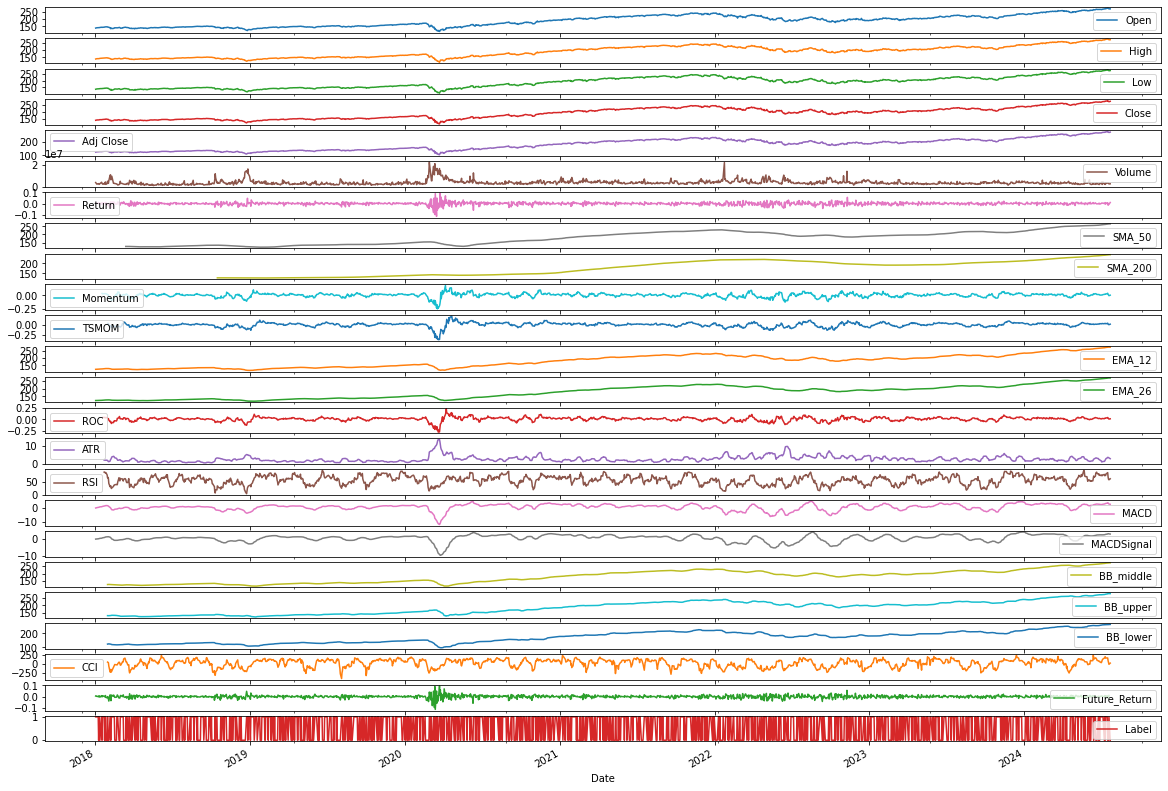

Add Momentum with p-value 2.2966429584157603e-40
Add MACD with p-value 1.9391395257010092e-14
Add MACDSignal with p-value 6.233459070248502e-30
Selected Features from Stepwise Regression for VTI: ['Momentum', 'MACD', 'MACDSignal']
Processing XLF...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Performing EDA for XLF
Descriptive Statistics:
               Open         High          Low        Close    Adj Close  \
count  1648.000000  1648.000000  1648.000000  1648.000000  1648.000000   
mean     31.795510    32.035388    31.551104    31.799211    29.872227   
std       5.425939     5.427999     5.423201     5.428920     5.999554   
min      18.440001    18.600000    17.490000    17.660000    16.212105   
25%      27.385000    27.600000    27.177500    27.420000    24.436510   
50%      31.685000    32.035000    31.325001    31.650000    30.439195   
75%      36.095001    36.322500    35.912499    36.122499    34.614993   
max      43.669998    44.110001    43.369999    43.820000    43.661648   

             Volume       Return       SMA_50      SMA_200     Momentum  ...  \
count  1.648000e+03  1647.000000  1599.000000  1449.000000  1638.000000  ...   
mean   5.482707e+07     0.000463    29.761138    29.516665     0.004347  ...   
std    2.544231e+07     0.015498     5.76967

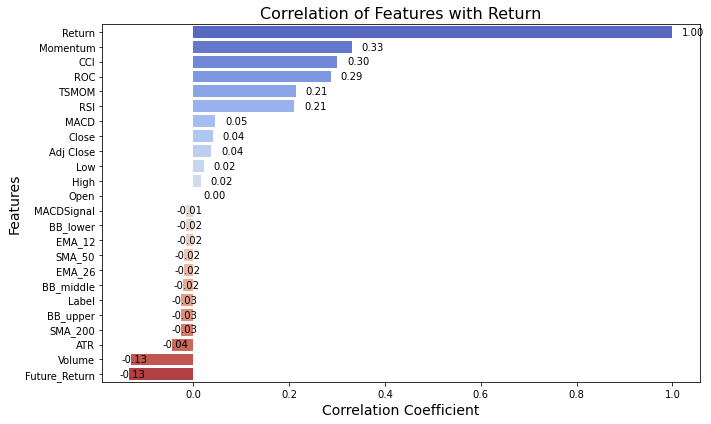

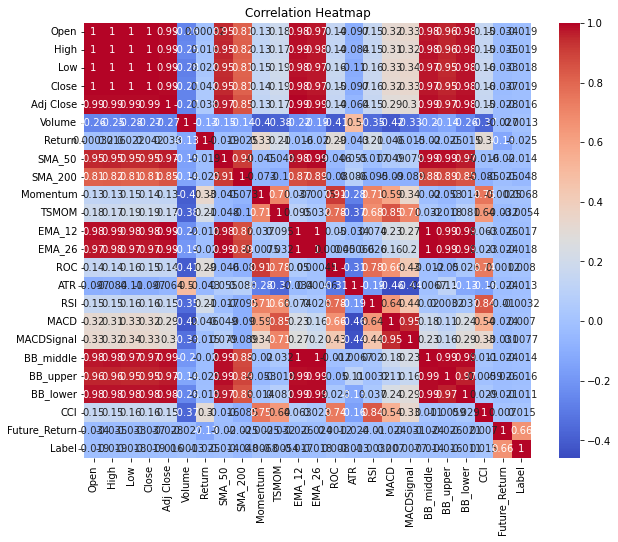

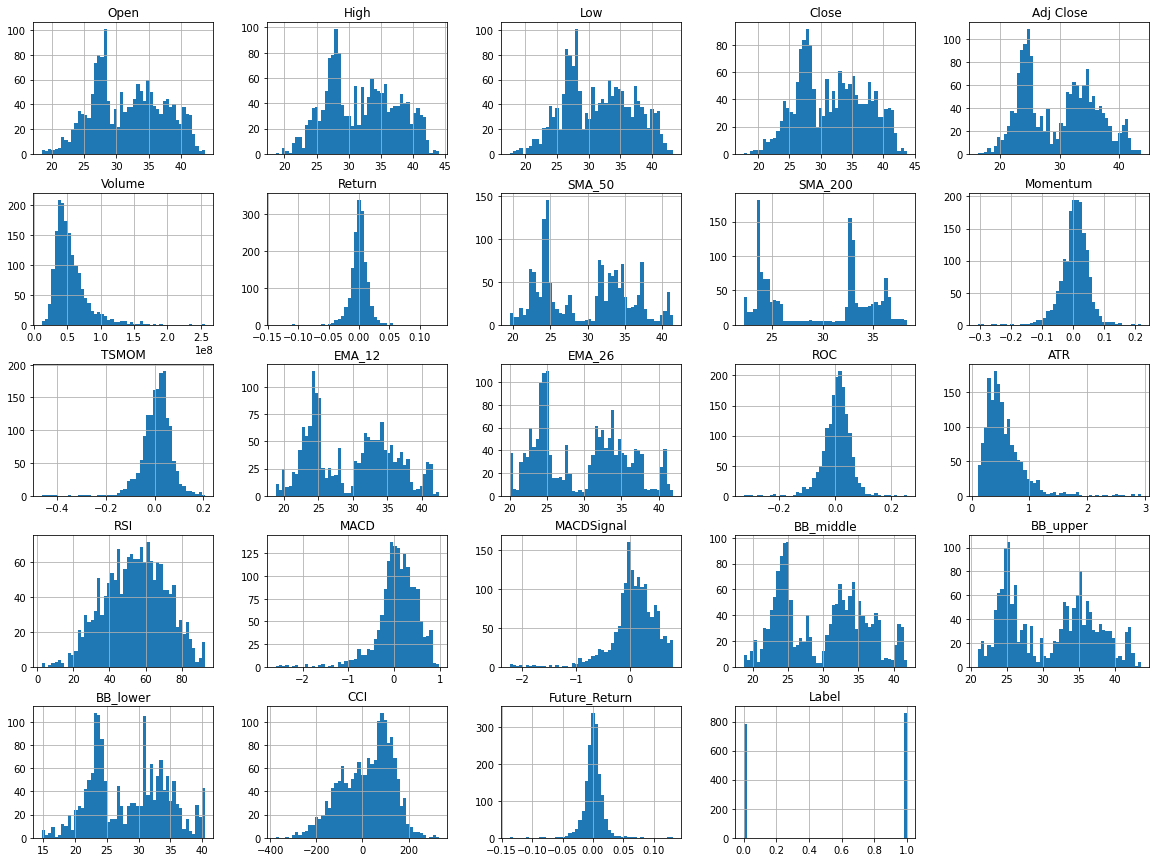

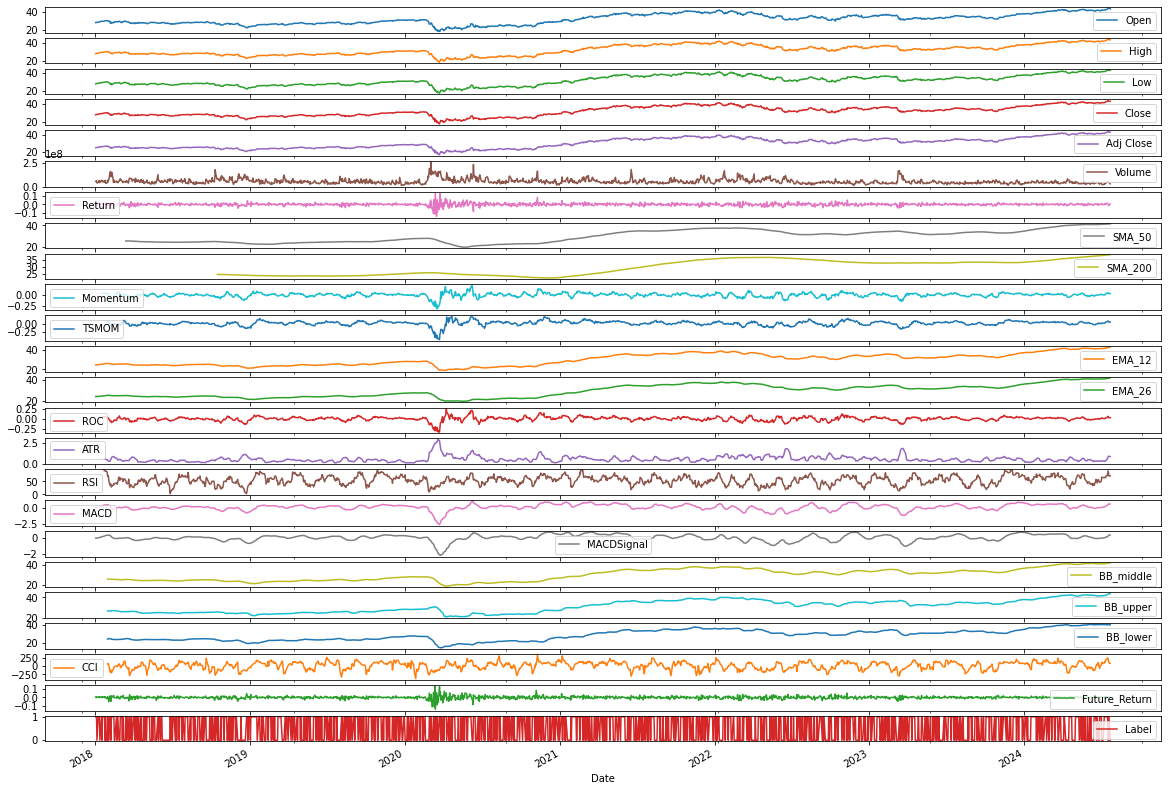

Add Momentum with p-value 4.6663640536941885e-39
Add MACD with p-value 6.711962224931435e-14
Add MACDSignal with p-value 1.022303424686132e-28
Selected Features from Stepwise Regression for XLF: ['Momentum', 'MACD', 'MACDSignal']
Processing XLK...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Performing EDA for XLK
Descriptive Statistics:
               Open         High          Low        Close    Adj Close  \
count  1648.000000  1648.000000  1648.000000  1648.000000  1648.000000   
mean    124.547706   125.584478   123.483064   124.606991   121.401529   
std      44.061628    44.337895    43.749996    44.074505    44.970755   
min      58.020000    59.360001    57.570000    57.619999    54.437618   
25%      79.507502    80.097498    78.957499    79.519999    75.640696   
50%     128.584999   129.715004   127.395000   128.919998   125.722954   
75%     154.665001   155.762501   153.772507   154.867500   151.251129   
max     238.039993   238.139999   234.570007   237.679993   237.253830   

             Volume       Return       SMA_50      SMA_200     Momentum  ...  \
count  1.648000e+03  1647.000000  1599.000000  1449.000000  1638.000000  ...   
mean   1.056383e+07     0.000938   120.713217   119.363019     0.009070  ...   
std    6.754985e+06     0.016498    42.86012

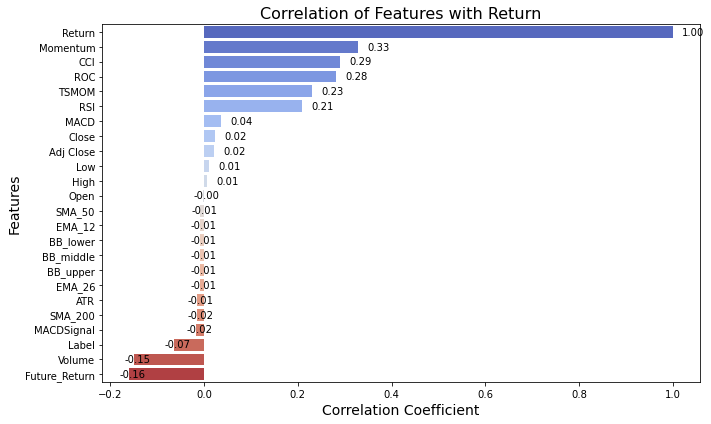

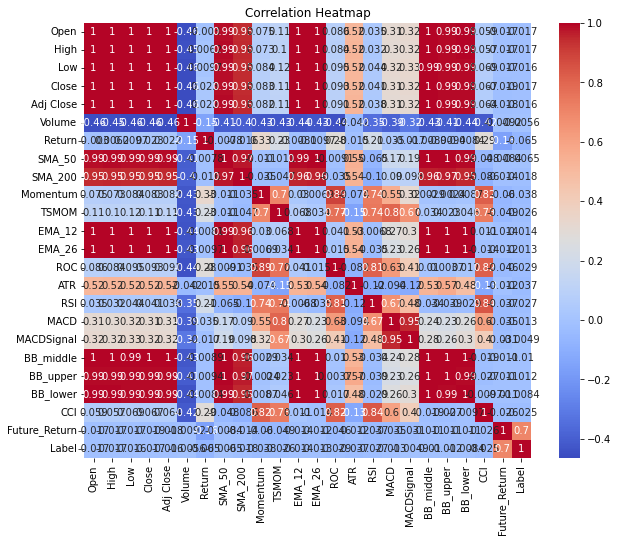

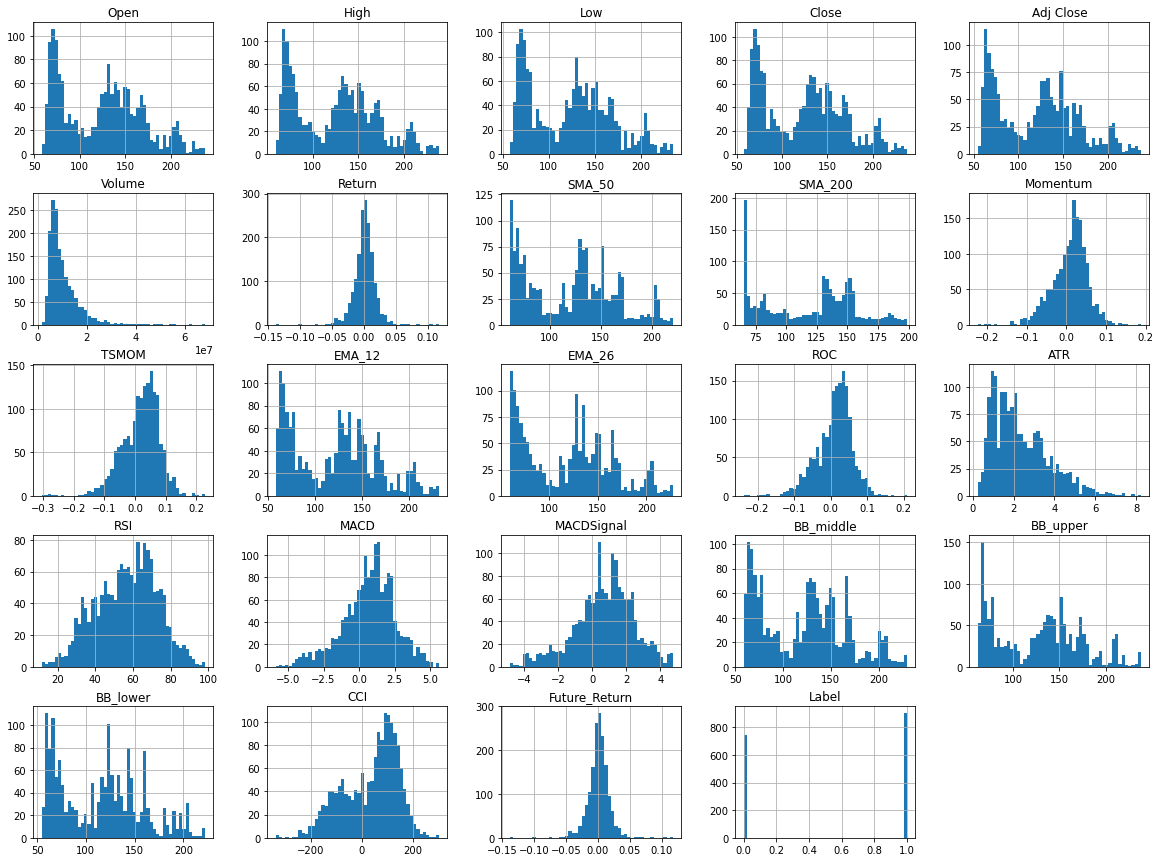

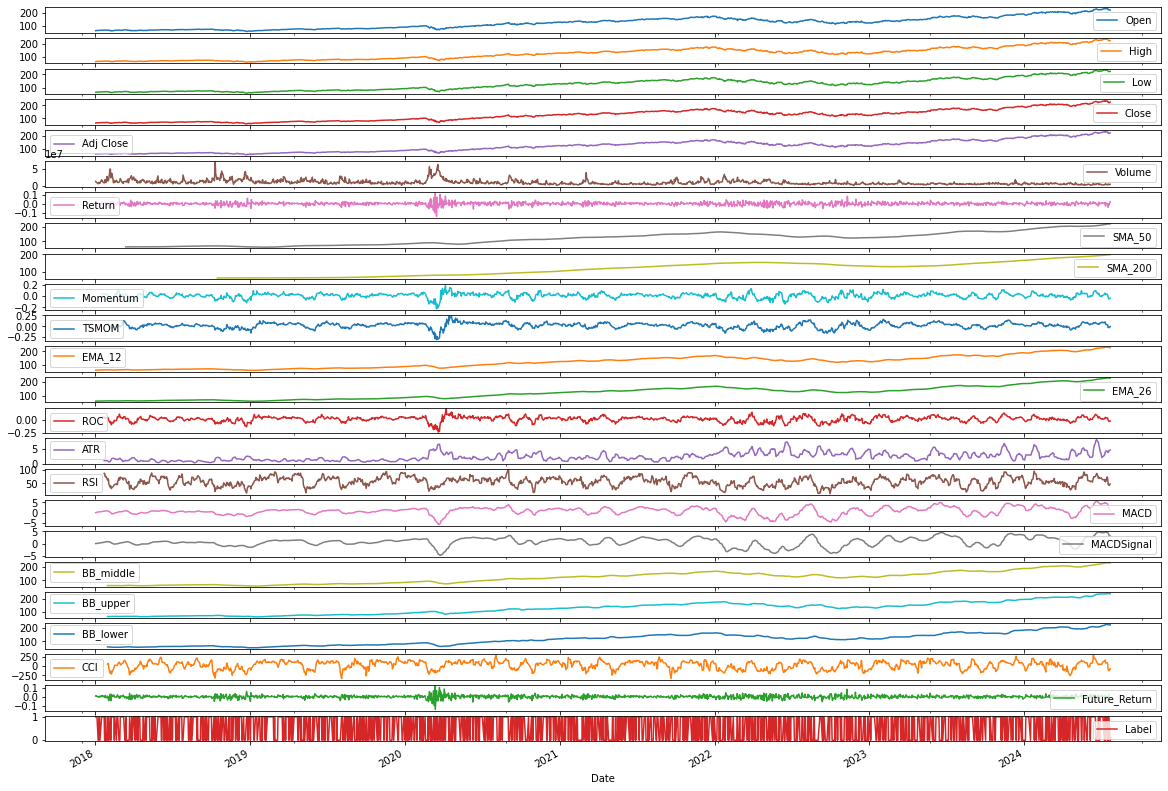

Add Momentum with p-value 1.0056260834076818e-38
Add MACD with p-value 1.1674790515135535e-13
Add MACDSignal with p-value 1.8464481480004984e-23
Selected Features from Stepwise Regression for XLK: ['Momentum', 'MACD', 'MACDSignal']


In [4]:
# Main execution loop for multiple tickers (Performing EDA before feature selection)
tickers = ['SPY', 'QQQ', 'DIA', 'IWM', 'VTI', 'XLF', 'XLK']
start_date = '2018-01-01'
end_date = '2024-07-23'

for ticker in tickers:
    print(f"Processing {ticker}...")

    # Load data for each ticker
    data = load_data(ticker, start_date, end_date)

    # Calculate indicators and label
    data = calculate_indicators(data)
    data = generate_labels(data)

    # Perform EDA for each ticker
    print(f"Performing EDA for {ticker}")
    perform_eda(data)

    # Prepare data for stepwise regression
    features, target = prepare_data_for_stepwise(data)

    # Perform stepwise regression to select the best features
    selected_features = stepwise_selection(features, target, max_features=3)
    print(f'Selected Features from Stepwise Regression for {ticker}: {selected_features}')

In [5]:
# Feature selection based on EDA and Stepwise
def selected_feature_columns(data):
    label = data['Label']
    returns = data['Return']

    data['Log_SMA_50'] = np.log1p(data['SMA_50'])
    selected_columns = ['TSMOM', 'MACD']
    selected_data = data[selected_columns]

    selected_data['Label'] = label
    selected_data['Return'] = returns

    return selected_data

# Train voting classifier with regularization
def train_voting_classifier_with_regularization(data):
    features = data.drop(columns=['Label', 'Return']).dropna()
    labels = data['Label'].reindex(features.index).dropna()

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=0.95)  # Keep 95% Variance
    features_pca = pca.fit_transform(features_scaled)

    tscv = TimeSeriesSplit(n_splits=5)

    rf = RandomForestClassifier(random_state=42)
    rf_param_grid = {'n_estimators': [50], 'max_depth': [3], 'min_samples_split': [30], 'min_samples_leaf': [20]}
    rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=tscv, scoring='accuracy')
    rf_grid_search.fit(features_pca, labels)
    best_rf = rf_grid_search.best_estimator_

    svm = SVC(probability=True, random_state=42)
    svm_param_grid = {'C': [0.1, 1], 'gamma': [0.01, 0.1]}
    svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=tscv, scoring='accuracy')
    svm_grid_search.fit(features_pca, labels)
    best_svm = svm_grid_search.best_estimator_

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', reg_alpha=0.1, reg_lambda=0.1)
    xgb_param_grid = {'n_estimators': [50], 'learning_rate': [0.01], 'max_depth': [3], 'reg_alpha': [0.5], 'reg_lambda': [0.5]}
    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=tscv, scoring='accuracy')
    xgb_grid_search.fit(features_pca, labels)
    best_xgb = xgb_grid_search.best_estimator_

    voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('svm', best_svm), ('xgb', best_xgb)], voting='soft')

    cv_scores = cross_val_score(voting_clf, features_pca, labels, cv=tscv, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean()}")

    voting_clf.fit(features_pca, labels)

    return voting_clf, scaler, pca

# Apply the strategy with PCA
def apply_strategy_with_pca(data, model, scaler, pca):
    features_columns = ['TSMOM', 'MACD']
    features = data[features_columns].dropna()
    original_index = features.index

    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    predicted_signal = model.predict(features_pca)

    data.loc[original_index, 'Predicted_Signal'] = predicted_signal
    data['Position'] = data['Predicted_Signal']
    data['Position'] = data['Position'].shift()
    data['Position'].fillna(0, inplace=True)

    data['Strategy_Return'] = data['Return'] * data['Position']
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

    return data

# Calculate performance metrics
def calculate_performance(data):
    performance_list = []
    years = data.index.year.unique()

    for year in years:
        yearly_data = data[data.index.year == year]
        yearly_data = yearly_data.dropna(subset=['Strategy_Return'])

        if len(yearly_data) == 0:
            continue

        start_date = yearly_data.index.min().strftime('%Y-%m-%d')
        end_date = yearly_data.index.max().strftime('%Y-%m-%d')

        num_days = trading_days(start_date, end_date)

        annualized_return = (1 + yearly_data['Strategy_Return']).prod() ** (252 / num_days) - 1

        if yearly_data['Strategy_Return'].std() != 0:
            sharpe_ratio = yearly_data['Strategy_Return'].mean() / yearly_data['Strategy_Return'].std() * np.sqrt(252)
        else:
            sharpe_ratio = 0

        performance_list.append({
            'Year': year,
            'Annualized Return': annualized_return,
            'Sharpe Ratio': sharpe_ratio
        })

    performance = pd.DataFrame(performance_list)
    return performance

Processing SPY...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Label'] = label
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u


Cross-validation scores: [0.52767528 0.58671587 0.53136531 0.4797048  0.57195572]
Mean accuracy: 0.5394833948339484


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[original_index, 'Predicted_Signal'] = predicted_signal
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = data['Predicted_Signal']
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Performance for SPY:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.097339     -0.523775
1  2019           0.312239      2.235602
2  2020           0.200500      0.717743
3  2021           0.308460      2.143800
4  2022          -0.134591     -0.478463
5  2023           0.295402      2.058779
6  2024           0.338204      2.765145


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/1802885688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()


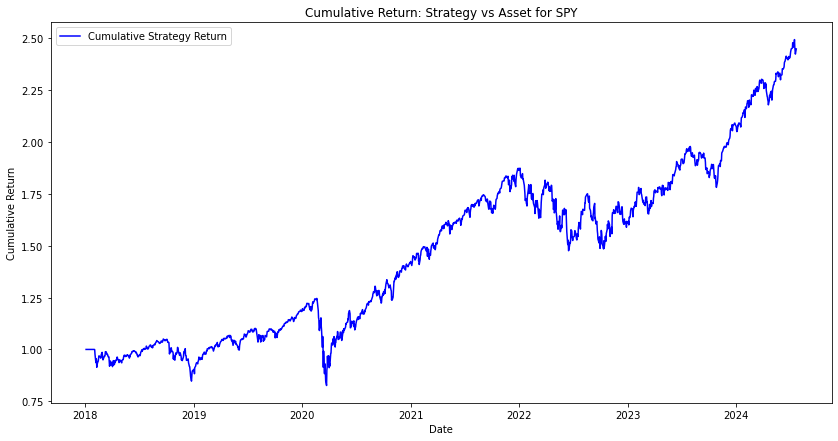

Processing QQQ...
[*********************100%%**********************]  1 of 1 completed


/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Label'] = label
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cross-validation scores: [0.56457565 0.60885609 0.53136531 0.50184502 0.58671587]
Mean accuracy: 0.5586715867158671


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[original_index, 'Predicted_Signal'] = predicted_signal
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = data['Predicted_Signal']
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Performance for QQQ:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.082306     -0.266289
1  2019           0.389615      2.114281
2  2020           0.691587      1.675663
3  2021           0.274197      1.421563
4  2022          -0.297924     -0.942611
5  2023           0.705516      3.161292
6  2024           0.407921      2.298012


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/1802885688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()


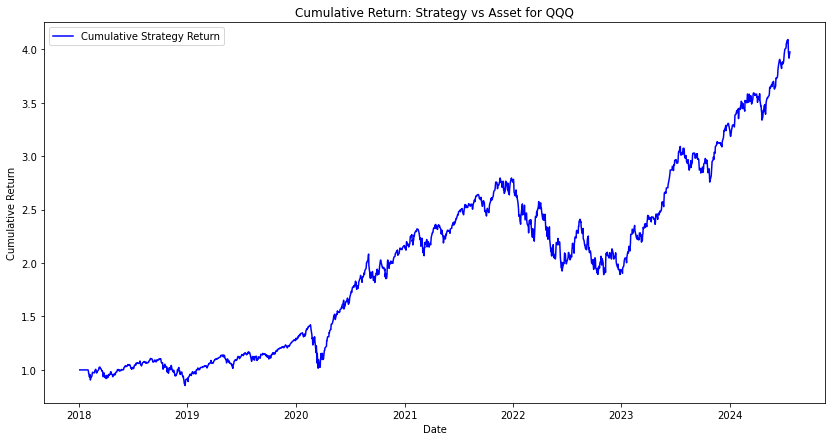

Processing DIA...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Label'] = label
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u


Cross-validation scores: [0.4797048  0.60147601 0.53136531 0.49077491 0.57564576]
Mean accuracy: 0.5357933579335794


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[original_index, 'Predicted_Signal'] = predicted_signal
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = data['Predicted_Signal']
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Performance for DIA:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.090381     -0.445829
1  2019           0.250266      1.846182
2  2020           0.095507      0.433605
3  2021           0.208258      1.599161
4  2022          -0.070423     -0.270729
5  2023           0.161571      1.369857
6  2024           0.154298      1.514412


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/1802885688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()


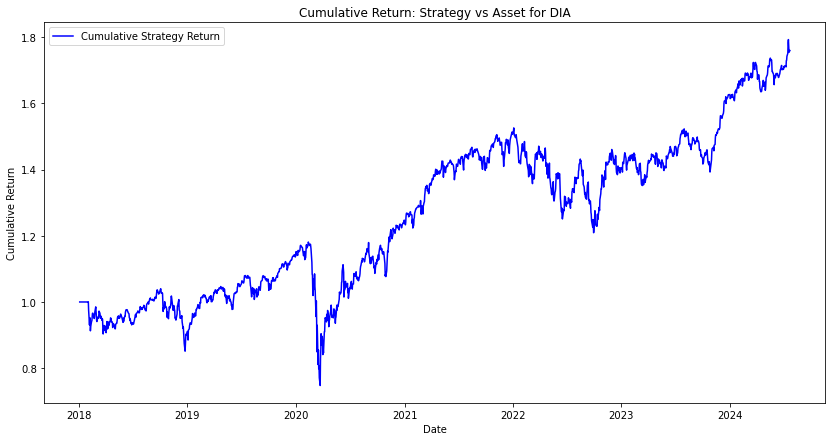

Processing IWM...
[*********************100%%**********************]  1 of 1 completed


/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Label'] = label
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cross-validation scores: [0.51660517 0.55719557 0.4797048  0.50922509 0.51660517]
Mean accuracy: 0.5158671586715867


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[original_index, 'Predicted_Signal'] = predicted_signal
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = data['Predicted_Signal']
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Performance for IWM:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.134373     -0.728885
1  2019           0.253897      1.492384
2  2020           0.230566      0.718717
3  2021           0.144616      0.735773
4  2022          -0.176411     -0.555107
5  2023           0.169731      0.881099
6  2024           0.255337      1.290666


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/1802885688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()


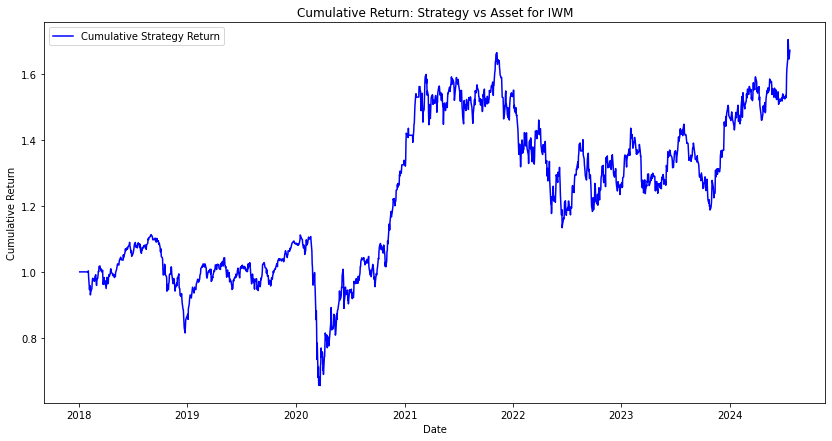

Processing VTI...
[*********************100%%**********************]  1 of 1 completed

/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Label'] = label
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u


Cross-validation scores: [0.54612546 0.60885609 0.5202952  0.50184502 0.53874539]
Mean accuracy: 0.5431734317343173


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[original_index, 'Predicted_Signal'] = predicted_signal
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = data['Predicted_Signal']
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Performance for VTI:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.100213     -0.555254
1  2019           0.306686      2.185074
2  2020           0.220119      0.753168
3  2021           0.271967      1.841608
4  2022          -0.170607     -0.630298
5  2023           0.284530      1.931186
6  2024           0.314386      2.539464


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/1802885688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()


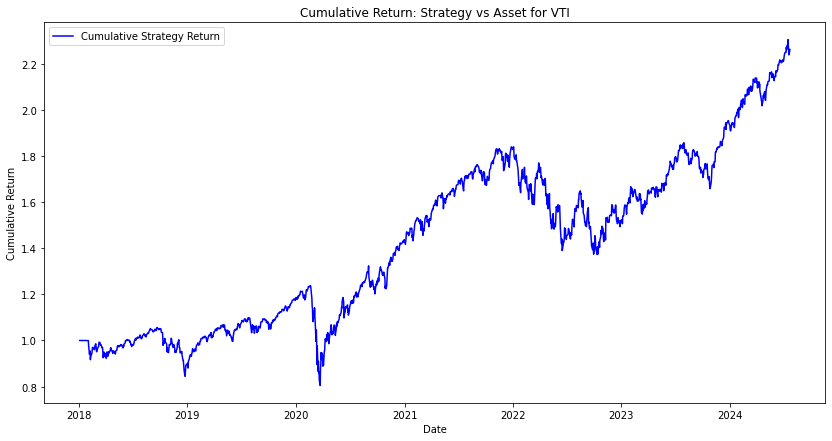

Processing XLF...
[*********************100%%**********************]  1 of 1 completed


/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Label'] = label
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cross-validation scores: [0.49815498 0.49446494 0.49815498 0.49446494 0.56457565]
Mean accuracy: 0.5099630996309964


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[original_index, 'Predicted_Signal'] = predicted_signal
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = data['Predicted_Signal']
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Performance for XLF:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.129814     -0.692948
1  2019           0.377005      2.231987
2  2020           0.478833      1.138807
3  2021           0.407748      1.948034
4  2022           0.016281      0.183257
5  2023           0.242136      1.566584
6  2024           0.310138      2.480712


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/1802885688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()


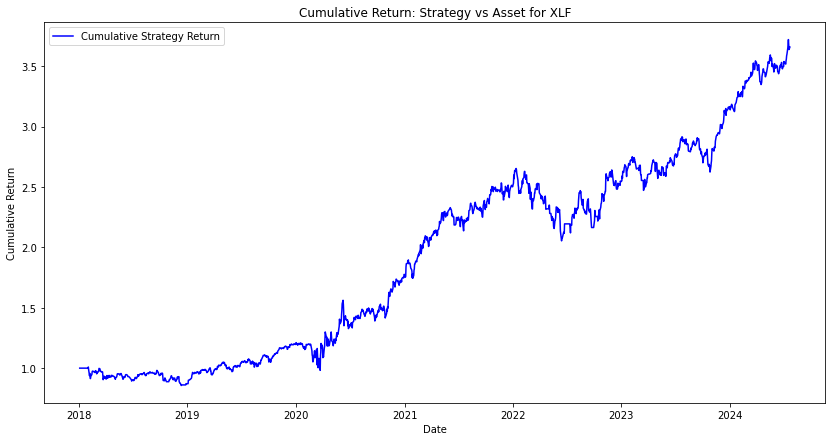

Processing XLK...
[*********************100%%**********************]  1 of 1 completed


/Users/Felix/opt/anaconda3/lib/python3.9/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Label'] = label
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Cross-validation scores: [0.54243542 0.56826568 0.50553506 0.46863469 0.57564576]
Mean accuracy: 0.5321033210332103


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[original_index, 'Predicted_Signal'] = predicted_signal
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'] = data['Predicted_Signal']
/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/469975165.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Performance for XLK:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.082034     -0.255790
1  2019           0.498558      2.333744
2  2020           0.572846      1.339732
3  2021           0.347440      1.642364
4  2022          -0.273377     -0.808981
5  2023           0.654488      2.842707
6  2024           0.509598      2.296104


/var/folders/93/zcxc8qx12411yl5_8p4j87m40000gn/T/ipykernel_80517/1802885688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Asset_Return'] = (1 + data['Return']).cumprod()


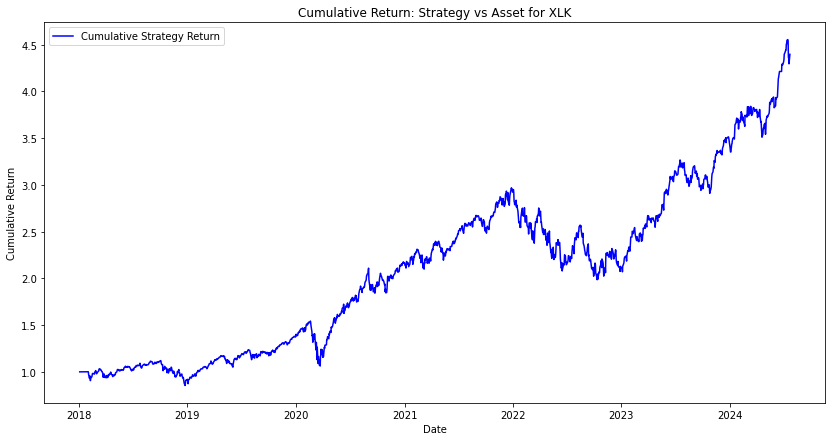


Performance metrics for SPY:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.097339     -0.523775
1  2019           0.312239      2.235602
2  2020           0.200500      0.717743
3  2021           0.308460      2.143800
4  2022          -0.134591     -0.478463
5  2023           0.295402      2.058779
6  2024           0.338204      2.765145

Performance metrics for QQQ:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.082306     -0.266289
1  2019           0.389615      2.114281
2  2020           0.691587      1.675663
3  2021           0.274197      1.421563
4  2022          -0.297924     -0.942611
5  2023           0.705516      3.161292
6  2024           0.407921      2.298012

Performance metrics for DIA:
   Year  Annualized Return  Sharpe Ratio
0  2018          -0.090381     -0.445829
1  2019           0.250266      1.846182
2  2020           0.095507      0.433605
3  2021           0.208258      1.599161
4  2022          -0.070423     -0.270729
5  2023 

In [6]:
performance_dict = {}

for ticker in tickers:
    print(f"Processing {ticker}...")

    # Load data for each ticker
    data = load_data(ticker, start_date, end_date)

    # Calculate indicators and label
    data = calculate_indicators(data)
    data = generate_labels(data)

    # Select features for model training
    data = selected_feature_columns(data)

    # Train the voting classifier with regularization
    voting_model, scaler, pca = train_voting_classifier_with_regularization(data)

    # Apply the model to create the strategy
    data = apply_strategy_with_pca(data, voting_model, scaler, pca)

    # Calculate performance metrics
    performance = calculate_performance(data)

    # Save the performance data in a dictionary
    performance_dict[ticker] = performance

    # Display the performance including the Sharpe ratio
    print(f"Performance for {ticker}:")
    print(performance)
    
    visualize_strategy_vs_asset(data, ticker)

# After looping through all tickers, display performance for each
for ticker, perf in performance_dict.items():
    print(f"\nPerformance metrics for {ticker}:")
    print(perf)